# Patient Readmission Prediction

## Authors 
- Dustin Pulver
- Alex Koch
- Apollo Lin


All Libraries used in this assignment are displayed in the cell below. Running the below cell should be all the is required to properly install these libraries into this environment. The cell below it has code to install packages if for some reason it does not work in the first cell. 

You will need to have two csv files downloaded in your google drive. The third cell is run to mount to your google drive. if you place the csv files in folders with the same name as mine it should run easily. 

files
*   C2T1_Train.csv
*   C2T1_Train.csv


# Task: Perdict patients readmission to the hospital.

The goal of this task is to train a predictive model to predict whether a patient will be readmitted to the hospital or not. This is a simply binary classification problem, although the bonus aspect of this problem asks to predict whether the patient will be readmitted in less than or more than 30 days. This now makes it a multi-class prediction problem, No admission, <30 days, or >30 days. Both binary classification and multi-class classification will be conducted in the modelling phase. The majority of the data preprocessing stage will be the same for both problems, with slight modifications to account for the change in number of classes in the target feature. 



In [48]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
# !pip install seaborn

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_train = pd.read_csv('/content/gdrive/MyDrive/CISC_451_AS2/C2T1_Train.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/CISC_451_AS2/C2T1_Test.csv')
data_train.shape

(90766, 50)

# Exploration

The data exploration stage will consist of the following;

*   Target feature balance check
*   Null value check
*   Correltaiton analysis







In [5]:
print(data_train.columns)

Index(['encounter_id2', 'patient_nbr2', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [6]:
data_train['readmitted']

0         NO
1         NO
2         NO
3        >30
4        >30
        ... 
90761    >30
90762     NO
90763     NO
90764     NO
90765     NO
Name: readmitted, Length: 90766, dtype: object

In [7]:
data_train['readmitted'].describe()

count     90766
unique        3
top          NO
freq      49361
Name: readmitted, dtype: object

In [8]:
data_train.readmitted.unique()

array(['NO', '>30', '<30'], dtype=object)

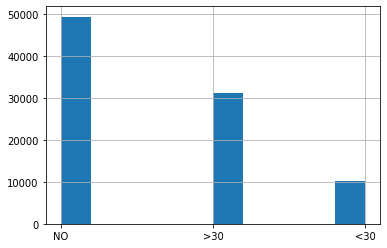

In [9]:
data_train['readmitted'].hist()

When looking at the target class, readmitted, we can see there are 90,766 data samples, with 3 unique values, 'NO', '>30', '<30'. The about histogram shows the distribution on a univariate scale of the readmitted target feature. The histogram shows the imbalance in the dataset, with being readmitted <30 days has almost 5 times less occurrences than No readmittance. This imbalance will make it harder for the predictive model to perform well, further techniques in the modelling phase will be implemented to adjust for the imbalance. 



The next exploratory step will be to determine the frequency of null values within each feature. Once this is determined the information will be used in the data preparation stage to either eliminate features or to replace the missing values. 

In [10]:
data_train.isnull().sum()

encounter_id2               0
patient_nbr2                0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

The null values are not appearing as they are represented with '?' question mark string values. I will now convert these values to NaN values that can be used with other built in packages. 

In [11]:
features_numeric = list(data_train.select_dtypes(include=['int64']))
features_categorical = list(data_train.select_dtypes(include=['object']))

In [12]:
convert_dict = {}

for i in features_categorical:
    convert_dict[i] = 'string'     
 
data_train = data_train.astype(convert_dict)
print(data_train.dtypes)

encounter_id2                int64
patient_nbr2                 int64
race                        string
gender                      string
age                         string
weight                      string
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  string
medical_specialty           string
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      string
diag_2                      string
diag_3                      string
number_diagnoses             int64
max_glu_serum               string
A1Cresult                   string
metformin                   string
repaglinide                 string
nateglinide                 string
chlorpropamide              string
glimepiride         

In [13]:
data_train.replace('?', np.nan, inplace=True)

In [14]:
data_train.isnull().sum() 

encounter_id2                   0
patient_nbr2                    0
race                         2207
gender                          0
age                             0
weight                      87840
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  38730
medical_specialty           43674
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         17
diag_2                        336
diag_3                       1357
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

The NULL values are now present, to deal with these null values steps will be taken in the data preperation phase

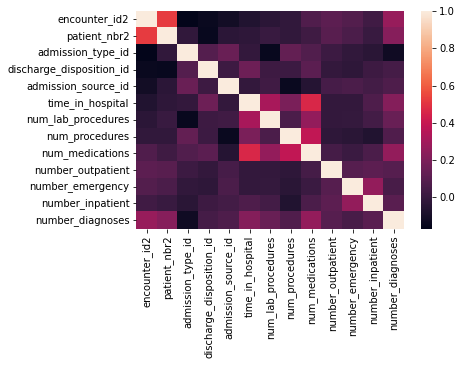

In [15]:
sns.heatmap(data_train.corr());

From this we can see that patient ID and encounter ID are highly correlated, as well as number of medications and time in hospital. If two features which are highly correlated are both included in a model this tends to lead to worse performance in the data preparation stage some of these features will be removed

# Data preparation

The null values are now visable. 

*   race                         2207
*   weight                      87840
*   payer_code                  38730
*   medical_specialty           43674
*   diag_1                         17
*   diag_2                        336
*   diag_3                       1357

With 90,766 total patients, there are only 3% of patients with weight values. The weight feature has too many missing values and thus can easily be eliminated from the dataset. 


Race logically should not have any impact on readmission of a patient, I am determined it can be removed from the dataset. It is removed for lack of relevance and a significant amount of missing values with no proper or logical way of imputation. 


medical_specialty, is the specialty of the admitting physician, i.e. cardiology, internal medicine, general practice. I again do not believe this is relevant to the readmittance of a patient. Since the feature has a significant amount of missing values and a lack of importance it can be eliminated.

payer code represents who paid for the admittance and medical care for each patient. This seems highly irrelevant to determine if a patient was readmitted. Since the feature has a significant amount of missing values and a lack of importance it can be eliminated.


The goal of the assignment is to determine if patients will be readmitted, if a patient does not a a diagnosis 1, then they can be removed from the dataset. If the patient doesn't have a diag_1 they wont have a diag_2 or diag_3 same can be applied if they dont have a diag_2 they wont have a diag_3 and so on. The approach is to drop all patients without a diagnosis 1 and replace all missing values in diagnosis 2 and 3 with 0's to represent no additional diagnosis. 









In [16]:
data_train_1 = data_train.dropna(subset=['diag_1'])

In [17]:
data_train_1.isnull().sum()

encounter_id2                   0
patient_nbr2                    0
race                         2205
gender                          0
age                             0
weight                      87823
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  38719
medical_specialty           43668
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                        335
diag_3                       1356
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [18]:
data_train_1['diag_2'] = data_train_1['diag_2'].fillna('0')
data_train_1['diag_3'] = data_train_1['diag_3'].fillna('0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
data_train_1.isnull().sum()

encounter_id2                   0
patient_nbr2                    0
race                         2205
gender                          0
age                             0
weight                      87823
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  38719
medical_specialty           43668
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [20]:
data_train_2 = data_train_1.drop(columns=['medical_specialty', 'payer_code','weight','race'])

In [21]:
data_train_2.isnull().sum()

encounter_id2               0
patient_nbr2                0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazo

Lastly each feature was examined by their attribute information to determine if, logically, they made sense to have in the final dataset. After examining all features and their information the following was determined to be irrelevant;

*   discharge_disposition_id
*   admission_source_id
*   time_in_hospital
*   encounter_id2 
*   patient_nbr2


Discharge disposition, is how the patient was discharged or released from the hospital. Since we are only concerned about readmission the way they were discarched seems irrelevant for this assignment. 

Admission source, similar to medical specialty as talked about earlier, is where the admission was from, i.e. physician referral, emergency room, etc.This again does not seem relevant to determine if the patient will be readmitted. 

Time in hospital is the number of days between admission and discharge. Again the days in hospital may be relevant to the problem although with logic I do not believe this will be useful in predicting readmission. Looking at the heat-map above number of medications and time in hospital are moderately correlated and thus one of these variables can be removed. 

Encounter id and patient number are both values which can be considered irrelevant to the prediction task at hand. They will provide helpful information for mapping the predictions within a csv file for the final step, although they are not relevant pieces of information for the prediction task. 


In [22]:
data_train_3 = data_train_2.drop(columns=['discharge_disposition_id', 'admission_source_id','time_in_hospital'])

Next examining the reaming categorical features to determine if they can be one hot encoded or if they contain too many categories and other methods are more suitable. The first stand out is age, which is not a numeric feature but rather a range of 10 years for each patient. This is represented as a nominal value, this would represent a large number of categories and i think in general the model would be able to handle numeric value with more proper intent. The following cells will take the average of the age range and assign the patient such average value for their age. i.e. if someone's age is 40-50 they would be assigned a numeric age of 45. 

All other nominal features have no more than 30 unique categories/values, with exception to the diagnosis' 1 2 and 3. These diagnosis include at least 800 unique values/categories, using one hot encoding can degrade the performance of the model as a large amount of encodings would be created increasing the dimensionality of the dataset. Other solutions such as mean target encoding or ordinal encoding, rely on attributes such as ordinality or other features to provide encodings. Since the categorical variables are all nominal, ordinal encoding cannot be used. With mean target encoding, another feature which gives information about the diagnosis would need to be used, although such features do not exist. There doesn't seem to be a clear solution, so we will take the trade off of an increase in dimensional for an increase in important information, using one hot encoding. 


In [23]:
data_train_3['age']

0         [80-90)
1        [90-100)
2         [40-50)
3         [40-50)
4         [50-60)
           ...   
90761     [70-80)
90762     [80-90)
90763     [70-80)
90764     [80-90)
90765     [70-80)
Name: age, Length: 90749, dtype: string

In [24]:
mean_age_list = []

for index, row in data_train_3.iterrows():
  mean_age = 0
  temp = row['age']
  temp_0 = temp[1:2]
  if(temp_0 == '0'):
    mean_age = 5
    mean_age_list.append(mean_age)
  elif(temp_0 == '9'):
    mean_age = 95
    mean_age_list.append(mean_age)
  else:
    temp_first = int(temp[1:3])
    temp_second = int(temp[4:6])
    mean_age = (temp_first + temp_second)/2
    mean_age_list.append(int(mean_age))

data_train_3['age'] = mean_age_list



In [25]:
data_train_3['age']
  

0        85
1        95
2        45
3        45
4        55
         ..
90761    75
90762    85
90763    75
90764    85
90765    75
Name: age, Length: 90749, dtype: int64

The last remaining step is to add an additional column for the binary prediction task, readmittance or not. The current readmittance column which has the 3 classes included (<30, >30, NO) will not be replaced as it will be used for the bonus task. For each task, either binary or multi-class prediction, the data-frame will be altered to include the correct information. 


In [26]:
data_train_3['readmitted_binary'] = ''
binary_list = []

for index, row in data_train_3.iterrows():
  temp = row['readmitted']
  if ((temp == '<30' ) or (temp == '>30' )):
    binary_list.append(1)
  else:
    binary_list.append(0)

data_train_3['readmitted_binary'] = binary_list


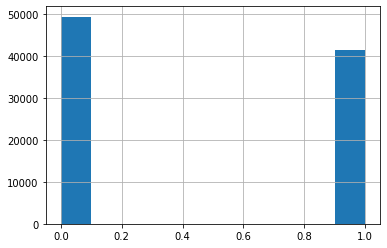

In [27]:
data_train_3['readmitted_binary'].hist()

In [28]:
data_train_final = data_train_3.drop(columns=['encounter_id2','patient_nbr2'])

As seen previously with the multi-class target feature readmittence there was class imbalance, when we convert this to a binary feature the distribution becomes much more even. 

# Modeling

For model training in this assignment I will be using pipelines. The purpose of these pipelines are to streamline the process of hyper parameter tuning, preprocessing, model selection, cross validation, and testing. 

In [29]:
X_train_binary = data_train_final.drop(['readmitted','readmitted_binary'], axis=1)
y_train_binary = data_train_final['readmitted_binary']

In [30]:
features_numeric_final = list(X_train_binary.select_dtypes(include=['int64']))
features_categorical_final = list(X_train_binary.select_dtypes(include=['string']))

### Binary classification

For the binary classification task we will be using the XGBoost model or XGBClassifier. This is a gradient boosted decision tree model, it's hyper parameters will be tuned using a grid search and 5 fold cross validation. The pipeline is filled out with transformations for both categorical and numeric features to provide the necessary preprocessing steps. The grid-search will train and validate all combinations of hyper parameters to generate the most optimal set of hyper parameters and a trained version of the most optimal model. 

In [31]:
np.random.seed(0)

transformer_numeric = Pipeline( # transforms for numeric values in dataset
    steps=[
        ('scaler', StandardScaler()),# Standardize the feature set by removing the mean and scaling to unit variance.
        ('normalize', Normalizer())] # normalize each row's feature values.
)

transformer_categorical = Pipeline( # transforms for categorical values in dataset
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
        # encode all the categorical values with binary values
    ]
)

# Apply the above numeric and categgorical transformations to the whole dataset(dataframe)
preprocessor = ColumnTransformer( 
    transformers=[
        ('num', transformer_numeric, features_numeric_final),
        ('cat', transformer_categorical, features_categorical_final)
    ]
)

# Create a sklearn pipeline and complie the required steps
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier', XGBClassifier( # XGBoost the claddifier being used in this pipeline
           objective='binary:logistic', seed=1)) #objective='multi:softprob',num_class = 3 for multiclass
    ]
)

# prepare parameters and their possible values for the following gridsearch
param_grid = {
    'my_classifier__n_estimators': [5, 10, 25],
    'my_classifier__max_depth':[10, 20]
}

# Gridsearch with 5 k-fold validation
grid_search_binary = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=1,return_train_score=True)

grid_search_binary.fit(X_train_binary, y_train_binary)

print('best score {}'.format(grid_search_binary.best_score_))
print('best score {}'.format(grid_search_binary.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.675, test=0.610) total time=   4.1s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.676, test=0.624) total time=   3.4s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.682, test=0.587) total time=   3.4s
[CV 4/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.672, test=0.626) total time=   4.8s
[CV 5/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.676, test=0.619) total time=   3.4s
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.688, test=0.613) total time=   5.0s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.685, test=0.627) total time=   5.0s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_esti

### Validaiton Accuracy & Confusion matrix

To get a validation accuracy and a confusion matrix the best model produced by the grid search is validated from a sample of the dataset. This was done for each approach, these values can be found in the 'other approaches tried' section at the bottom of the notebook. 

In [33]:
X_train, X_val, y_train, y_val = train_test_split( X_train_binary, y_train_binary, test_size=0.33, random_state=42)

In [45]:
y_pred = grid_search_binary.predict(X_val)

In [49]:
accuracy_score(y_val, y_pred)

0.7031521303592895

In [47]:
confusion_matrix(y_val, y_pred)

array([[13359,  2797],
       [ 6093,  7699]])

### Multi Class Classificaiton

For the multi class classification task we will be using the same XGBoost model or XGBClassifier. This model will again be tuned using a grid search and 5 fold cross validation. The pipeline is filled out with the same transformations for both categorical and numeric features to provide the necessary preprocessing steps. We saw earlier that with the multi-class problem there exists a class imbalance, to help the model deal with this we will introduce SMOTE. SMOTE over-samples the minority class by creating synthetic examples to over populate said minority class, therefore rebalancing the dataset for training purposes. stratified k-fold will be added to maintain this class rebalance when generating the folds for the cross validation steps. 

In [50]:
X_train_multi_class = data_train_final.drop(['readmitted','readmitted_binary'], axis=1)
y_train_multi_class = data_train_final['readmitted']

In [51]:

np.random.seed(0)

transformer_numeric = Pipeline( # transforms for numeric values in dataset
    steps=[
        ('scaler', StandardScaler()),# Standardize the feature set by removing the mean and scaling to unit variance.
        ('normalize', Normalizer())] 
)

transformer_categorical = Pipeline( # transforms for categorical values in dataset
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
        # encode all the categorical values with binary values
    ]
)

# Apply the above numeric and categgorical transformations to the whole dataset(dataframe)
preprocessor = ColumnTransformer( 
    transformers=[
        ('num', transformer_numeric, features_numeric_final),
        ('cat', transformer_categorical, features_categorical_final)
    ]
)

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)), #add SMOTE to the pipeline steps
        ('my_classifier', XGBClassifier( # XGBoost the classifier being used in this pipeline
            objective='multi:softprob',num_class = 3, seed=1))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

# prepare parameters and their possible values for the following gridsearch
param_grid = {
    'my_classifier__n_estimators': [5, 10, 25],
    'my_classifier__max_depth':[10, 20]
}

# Gridsearch with 5 k-fold validation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1,return_train_score=True)

grid_search.fit(X_train_multi_class, y_train_multi_class)

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.578, test=0.545) total time= 1.2min
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.578, test=0.547) total time= 1.4min
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.572, test=0.548) total time= 1.3min
[CV 4/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.576, test=0.547) total time= 1.4min
[CV 5/5] END my_classifier__max_depth=10, my_classifier__n_estimators=5;, score=(train=0.576, test=0.554) total time= 1.3min
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.585, test=0.550) total time= 1.5min
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.587, test=0.554) total time= 1.4min
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_esti

In [52]:
X_train, X_val, y_train, y_val = train_test_split( X_train_multi_class, y_train_multi_class, test_size=0.33, random_state=42)

In [53]:
y_pred = grid_search.predict(X_val)

In [54]:
accuracy_score(y_val, y_pred)

0.7339054360892213

In [55]:
confusion_matrix(y_val, y_pred)

array([[  773,   426,  2144],
       [  105,  5869,  4475],
       [  152,   667, 15337]])

The below cell takes all the same preprocessing steps which were taken for the training set. 

In [ ]:

convert_dict_test = {}

for i in features_categorical_final:
    convert_dict_test[i] = 'string'     

data_test = data_test.astype(convert_dict_test)

data_test.replace('?', np.nan, inplace=True)

data_test_1 = data_test.dropna(subset=['diag_1'])

data_test_1['diag_2'] = data_test_1['diag_2'].fillna('0')
data_test_1['diag_3'] = data_test_1['diag_3'].fillna('0')


data_test_2 = data_test_1.drop(columns=['discharge_disposition_id', 'admission_source_id','time_in_hospital',
                                        'medical_specialty', 'payer_code','weight','race','readmitted'])

data_test_final = data_test_2.drop(columns=['encounter_id','patient_nbr'])

mean_age_list = []

for index, row in data_test_final.iterrows():
  mean_age = 0
  temp = row['age']
  temp_0 = temp[1:2]
  if(temp_0 == '0'):
    mean_age = 5
    mean_age_list.append(mean_age)
  elif(temp_0 == '9'):
    mean_age = 95
    mean_age_list.append(mean_age)
  else:
    temp_first = int(temp[1:3])
    temp_second = int(temp[4:6])
    mean_age = (temp_first + temp_second)/2
    mean_age_list.append(int(mean_age))

data_test_final['age'] = mean_age_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


The below two functions "get_submission_multiclass" and "get_submission_binary" were created to prepair a dataframe which can be easily converted to a csv file for submission.

In [ ]:
def get_submission_multiclass(saerch):

  # prepare submission:
  submission = pd.DataFrame()
  submission['encounter_id'] = data_test_2['encounter_id']
  submission['patient_nbr'] = data_test_2['patient_nbr']
  submission['readmitted_temp'] = list(grid_search.predict_proba(data_test_final))

  submission['readmitted'] = np.nan

  temp_val = []

  for index, row in submission.iterrows():
      temp = row['readmitted_temp']
      max_value = max(temp)
      index_max = list(temp).index(max_value)
      if index_max == 0:
        temp_val.append('<30')
      if index_max == 1:
        temp_val.append('>30')
      if index_max == 2:
        temp_val.append('NO')
  
  submission['readmitted'] = temp_val

  return  submission 
      

In [ ]:
def get_submission_binary(saerch):

  # prepare submission:
  submission = pd.DataFrame()
  submission['encounter_id'] = data_test_2['encounter_id']
  submission['patient_nbr'] = data_test_2['patient_nbr']
  submission['readmitted_temp'] = list(grid_search_binary.predict_proba(data_test_final))
  submission['readmitted'] = np.nan

  temp_val = []

  for index, row in submission.iterrows():
      temp = row['readmitted_temp']
      max_value = max(temp)
      index_max = list(temp).index(max_value)
      if index_max == 0:
        temp_val.append('NO')
      if index_max == 1:
        temp_val.append('YES')
  
  submission['readmitted'] = temp_val

  return  submission 
      

In [ ]:
sub = get_submission_binary(grid_search_binary)

In [ ]:
sub_multiclass = get_submission_multiclass(grid_search)

In [ ]:
submission = sub_multiclass.drop('readmitted_temp', axis=1)

In [ ]:
submission_binary = sub.drop('readmitted_temp', axis=1)

In [ ]:
submission_binary.to_csv('C2T1_Test_Labled_Binary.csv', index=False)
submission_binary

,encounter_id,patient_nbr,readmitted
0,168899775,88565423,NO
1,168901359,88590695,NO
2,168903045,61086362,NO
3,168903927,85993970,YES
4,168904515,45884291,NO
...,...,...,...
10995,206091009,93935111,NO
10996,206098845,112735382,NO
10997,206100591,89262995,YES
10998,206117205,106914191,YES


# Other Approaches Attempted

In the data preparation phase we converted age to a numeric value. We first trained a model with age as a nominal categorical feature which achieved 52% validation accuracy(1). We then tried changing age to a numerical value, this resulted in a increased performance of 57% validation accuracy(2). These were the first preprocessing steps, others followed leading to a final implementation with a 70% validation accuracy(5). 

It was debated to incorporate PCA into our pipeline to reduce the dimension of our dataset. Since PCA can only be used on numeric features, we first tried to apply it to only the numeric features, and leave the categorical features as is. This resulted in worse validation accuracy(3), and also did not reduce the dimension of our data set significantly as the majority of the features are categorical. 

The use of Adaboost and other simpler models such as SVM(4) were attempted. Adaboost is an alternative boosting model to XGBoost although after research, training , and testing it was determined that the research was correct in saying XGBoost generally outperforms adaboost. The simpler models such SVMs were trained and tested to familiarize the team with the processes of training in a pipeline. 

Below is a summary of all approaches, their validation accuracy and corresponding confusion matrix. 

Approach 6 is the bonus quesiton.

(1) preprocessing categorical Age with SVM
val accuracy = 53% 
```
[[12129,  10243],
[3549,  4027]]
```

(2) preprocessing numeric Age with SVM
val accuracy = 57% 

```
[[12379,  8943],
[4849,  3777]]
```

(3) preprocessing PCA with SVM  
val accuracy = 53% 

```
[[11279,  9213],
[4579,  4877]]
```

(4) Final preprocessing with SVM
val accuracy = 57% 

```
[[12530,  7145],
[6647,  3626]]
```

(5) Final preprocessing with XGBoost Binary Model

val accuracy = 70%
```
[[13359,  2797],
[ 6093,  7699]]
```
(6) Final preprocessing with XGBoost Multi-Class Model

val accuracy = 73%
```
[[  773,   426,  2144],
[  105,  5869,  4475],
[  152,   667, 15337]])

